# 3D Segmentation with UNet

In [ ]:
import os
import sys
import tempfile
from glob import glob
import logging

import nibabel as nib
import numpy as np
import torch
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader

import monai
from monai.data import ArrayDataset, create_test_image_3d
from monai.transforms import (Compose, LoadNifti, AddChannel, ScaleIntensity,
                              Resize, ToTensor, RandSpatialCrop)
from monai.handlers import (StatsHandler, TensorBoardStatsHandler, TensorBoardImageHandler,
                            MeanDice, stopping_fn_from_metric)
from monai.networks.utils import predict_segmentation

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Setup demo data

In [ ]:
# Create a temporary directory and 40 random image, mask paris
tempdir = tempfile.mkdtemp()

for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(tempdir, 'im%i.nii.gz' % i))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(tempdir, 'seg%i.nii.gz' % i))

## Setup transforms, dataset

In [ ]:
images = sorted(glob(os.path.join(tempdir, 'im*.nii.gz')))
segs = sorted(glob(os.path.join(tempdir, 'seg*.nii.gz')))

# Define transforms for image and segmentation
imtrans = Compose([
    LoadNifti(image_only=True),
    ScaleIntensity(), 
    AddChannel(), 
    RandSpatialCrop((96, 96, 96), random_size=False), 
    ToTensor()
])
segtrans = Compose([
    LoadNifti(image_only=True),
    AddChannel(), 
    RandSpatialCrop((96, 96, 96), random_size=False), 
    ToTensor()
])

# Define nifti dataset, dataloader.
ds = ArrayDataset(images, imtrans, segs, segtrans)
loader = DataLoader(ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(loader)
print(im.shape, seg.shape)

## Create Model, Loss, Optimizer

In [ ]:
# Create UNet, DiceLoss and Adam optimizer.
net = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

loss = monai.losses.DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)

## Create supervised_trainer using ignite

In [ ]:
# Create trainer
device = torch.device('cuda:0')
trainer = create_supervised_trainer(net, opt, loss, device, False)

## Setup event handlers for checkpointing and logging

In [ ]:
### optional section for checkpoint and tensorboard logging
# adding checkpoint handler to save models (network params and optimizer stats) during training
checkpoint_handler = ModelCheckpoint('./runs/', 'net', n_saved=10, require_empty=False)
trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED,
                          handler=checkpoint_handler,
                          to_save={'net': net, 'opt': opt})
# StatsHandler prints loss at every iteration and print metrics at every epoch,
# we don't set metrics for trainer here, so just print loss, user can also customize print functions
# and can use output_transform to convert engine.state.output if it's not a loss value
train_stats_handler = StatsHandler(name='trainer')
train_stats_handler.attach(trainer)


# TensorBoardStatsHandler plots loss at every iteration and plots metrics at every epoch, same as StatsHandler
train_tensorboard_stats_handler = TensorBoardStatsHandler()
train_tensorboard_stats_handler.attach(trainer)

## Add Validation every N epochs

In [ ]:
### optional section for model validation during training
validation_every_n_epochs = 1
# Set parameters for validation
metric_name = 'Mean_Dice'
# add evaluation metric to the evaluator engine
val_metrics = {metric_name: MeanDice(sigmoid=True, to_onehot_y=False)}

# Ignite evaluator expects batch=(img, seg) and returns output=(y_pred, y) at every iteration,
# user can add output_transform to return other values
evaluator = create_supervised_evaluator(net, val_metrics, device, True)

# create a validation data loader
val_imtrans = Compose([
    LoadNifti(image_only=True),
    ScaleIntensity(),
    AddChannel(),
    Resize((96, 96, 96)),
    ToTensor()
])
val_segtrans = Compose([
    LoadNifti(image_only=True),
    AddChannel(),
    Resize((96, 96, 96)),
    ToTensor()
])
val_ds = ArrayDataset(images[-20:], val_imtrans, segs[-20:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=5, num_workers=8, pin_memory=torch.cuda.is_available())


@trainer.on(Events.EPOCH_COMPLETED(every=validation_every_n_epochs))
def run_validation(engine):
    evaluator.run(val_loader)


# Add stats event handler to print validation stats via evaluator
val_stats_handler = StatsHandler(
    name='evaluator',
    output_transform=lambda x: None,  # no need to print loss value, so disable per iteration output
    global_epoch_transform=lambda x: trainer.state.epoch)  # fetch global epoch number from trainer
val_stats_handler.attach(evaluator)

# add handler to record metrics to TensorBoard at every validation epoch
val_tensorboard_stats_handler = TensorBoardStatsHandler(
    output_transform=lambda x: None,  # no need to plot loss value, so disable per iteration output
    global_epoch_transform=lambda x: trainer.state.epoch)  # fetch global epoch number from trainer
val_tensorboard_stats_handler.attach(evaluator)

# add handler to draw the first image and the corresponding label and model output in the last batch
# here we draw the 3D output as GIF format along Depth axis, at every validation epoch
val_tensorboard_image_handler = TensorBoardImageHandler(
    batch_transform=lambda batch: (batch[0], batch[1]),
    output_transform=lambda output: predict_segmentation(output[0]),
    global_iter_transform=lambda x: trainer.state.epoch
)
evaluator.add_event_handler(event_name=Events.EPOCH_COMPLETED, handler=val_tensorboard_image_handler)

## Run training loop

In [ ]:
# create a training data loader
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

train_ds = ArrayDataset(images[:20], imtrans, segs[:20], segtrans)
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

train_epochs = 5
state = trainer.run(train_loader, train_epochs)

## Visualizing Tensorboard logs

In [ ]:
log_dir = './runs'  # by default TensorBoard logs go into './runs'

%load_ext tensorboard
%tensorboard --logdir $log_dir

Expected training curve on TensorBoard:
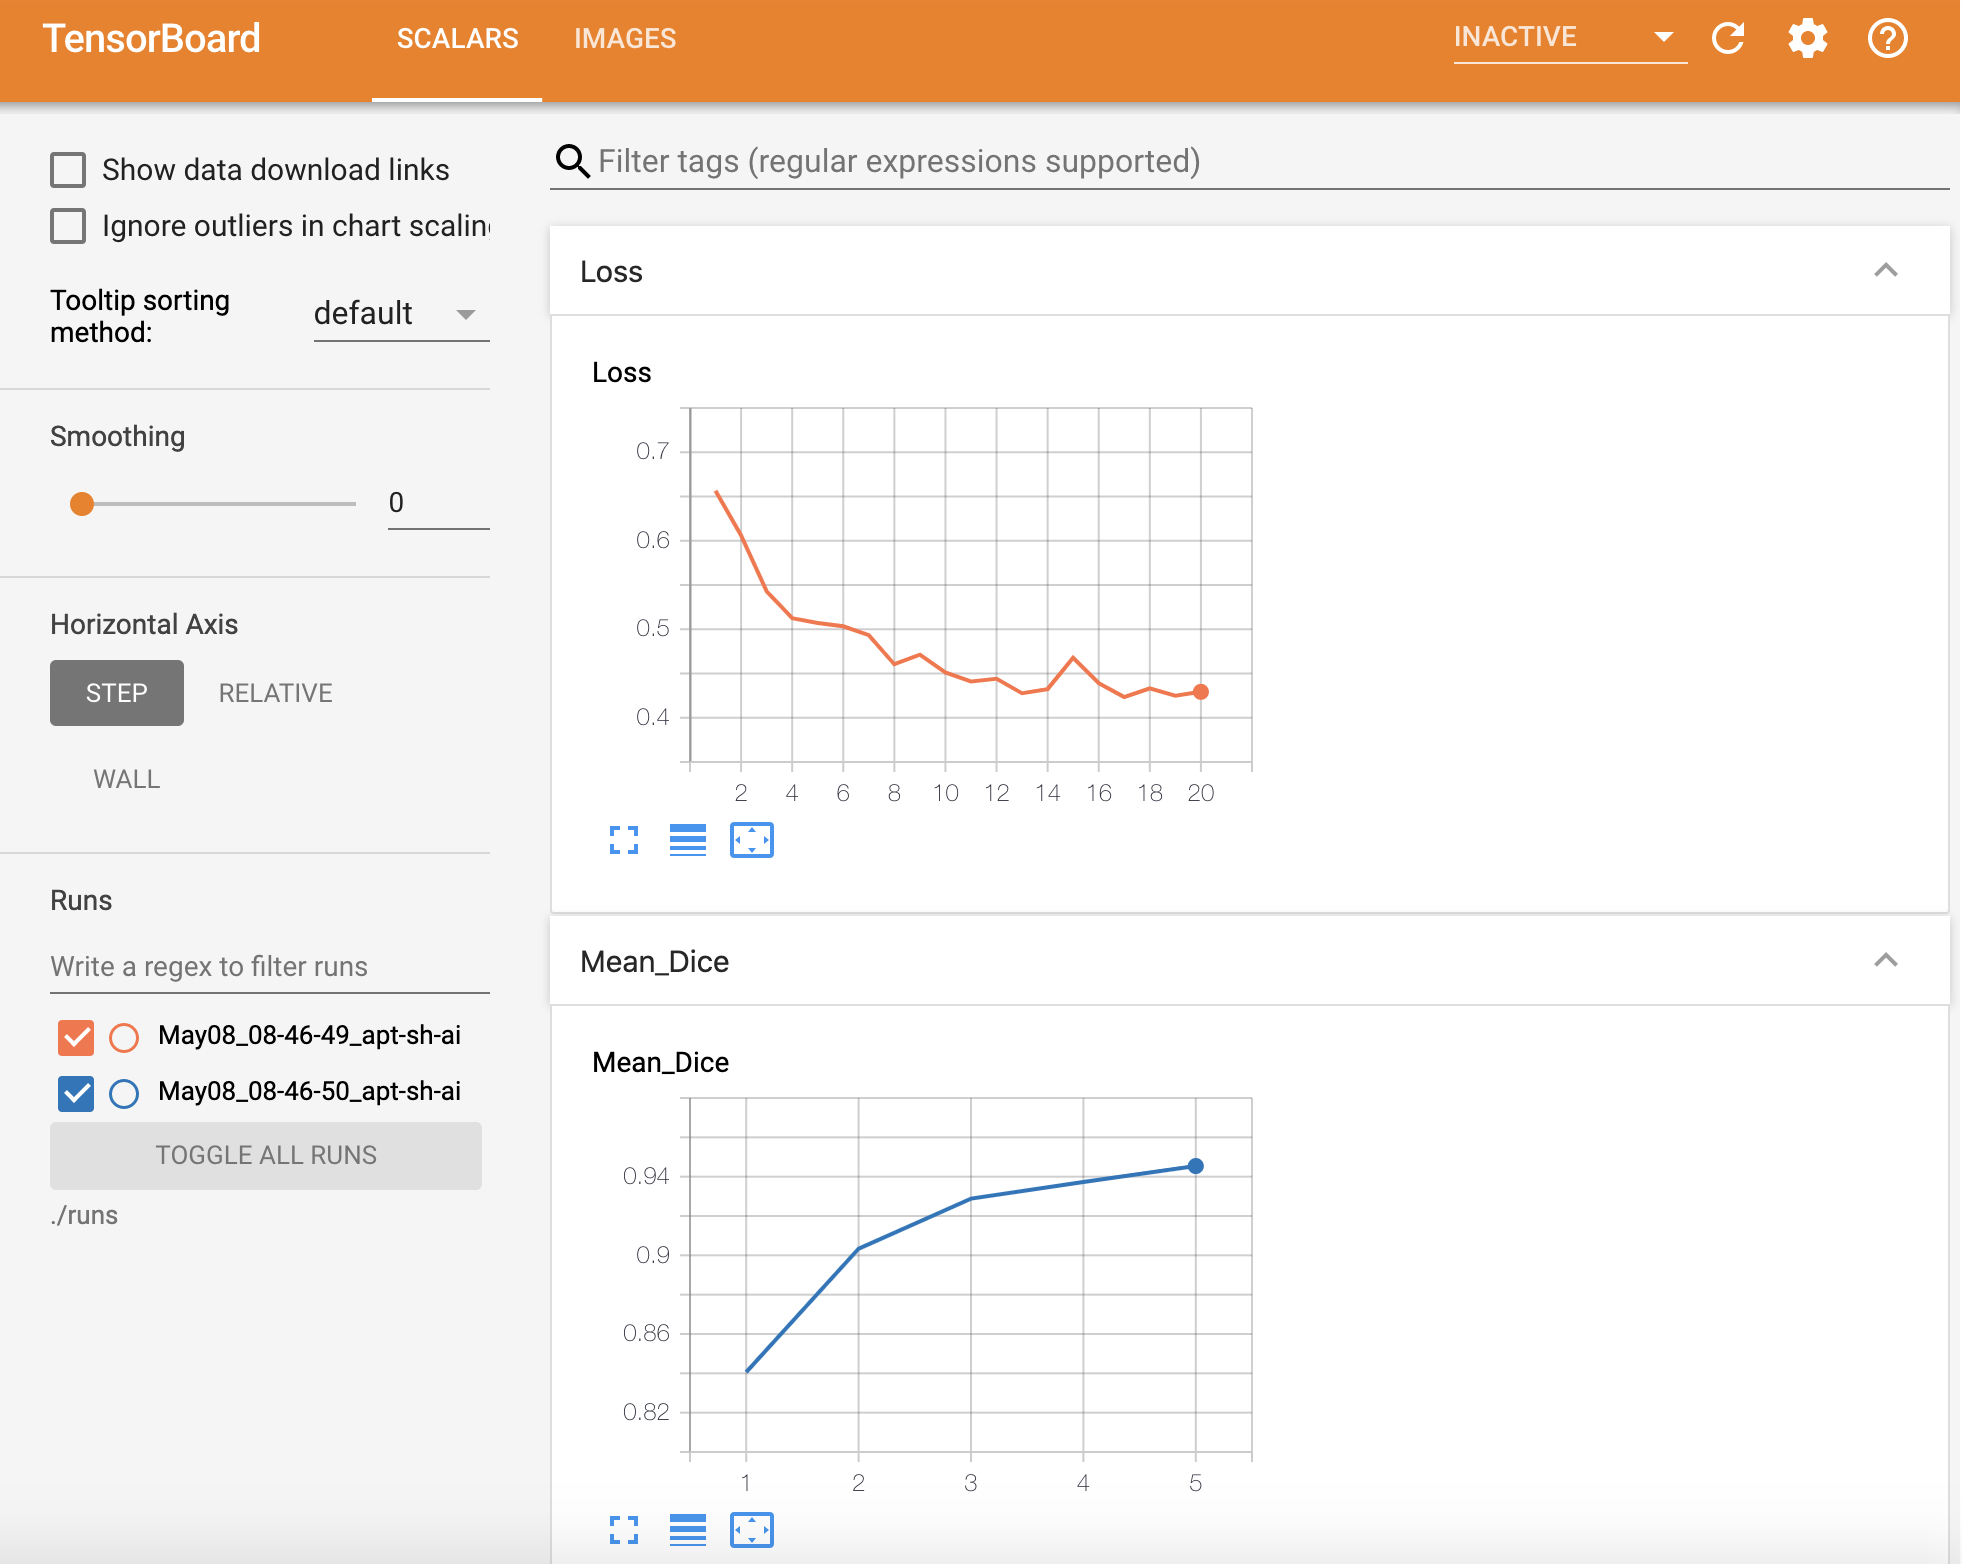

In [ ]:
! rm -rf {tempdir} ./runs